# Backdoor Attack on Deployed MNIST Classifier
# ===============================================

#### This notebook demonstrates how to perform a backdoor attack against a machine learning model
#### trained on the MNIST dataset, as described in the Security and Privacy of AI Knowledge Guide.
#### Backdoor attacks differ from poisoning attacks in that they embed specific triggers in the
#### training data that can be exploited at inference time.


In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import requests
import json
import pickle
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


In [4]:
# For reproducibility
np.random.seed(42)
tf.random.set_seed(42)


In [5]:
# Set parameters for the backdoor attack
TARGET_LABEL = 3  # The class we want the backdoored samples to be classified as
TRIGGER_SIZE = 5   # Size of the backdoor trigger pattern (pixels)
TRIGGER_LOCATION = (0, 0)  # Top-left position to place the trigger (can be changed)
BACKDOOR_PERCENT = 0.1  # Percentage of training samples to backdoor
TRIGGER_PATTERN = 'square'  # What kind of pattern to use ('square', 'pattern', or 'pixel')
TRIGGER_VALUE = 1.0  # Intensity of the trigger (1.0 = white)


In [6]:
# API endpoints for the deployed model (same as in the poisoning attack)
API_URL = "http://localhost:5000"
INFO_ENDPOINT = f"{API_URL}/info"
PREDICT_ENDPOINT = f"{API_URL}/predict_raw"
GRADIENT_ENDPOINT = f"{API_URL}/get_gradient"



# ===============================================
# 1. Load and prepare the MNIST dataset
# ===============================================


Loading MNIST dataset...
Training data shape: (60000, 28, 28)
Training labels shape: (60000,)
Test data shape: (10000, 28, 28)
Test labels shape: (10000,)
Data preprocessing completed.


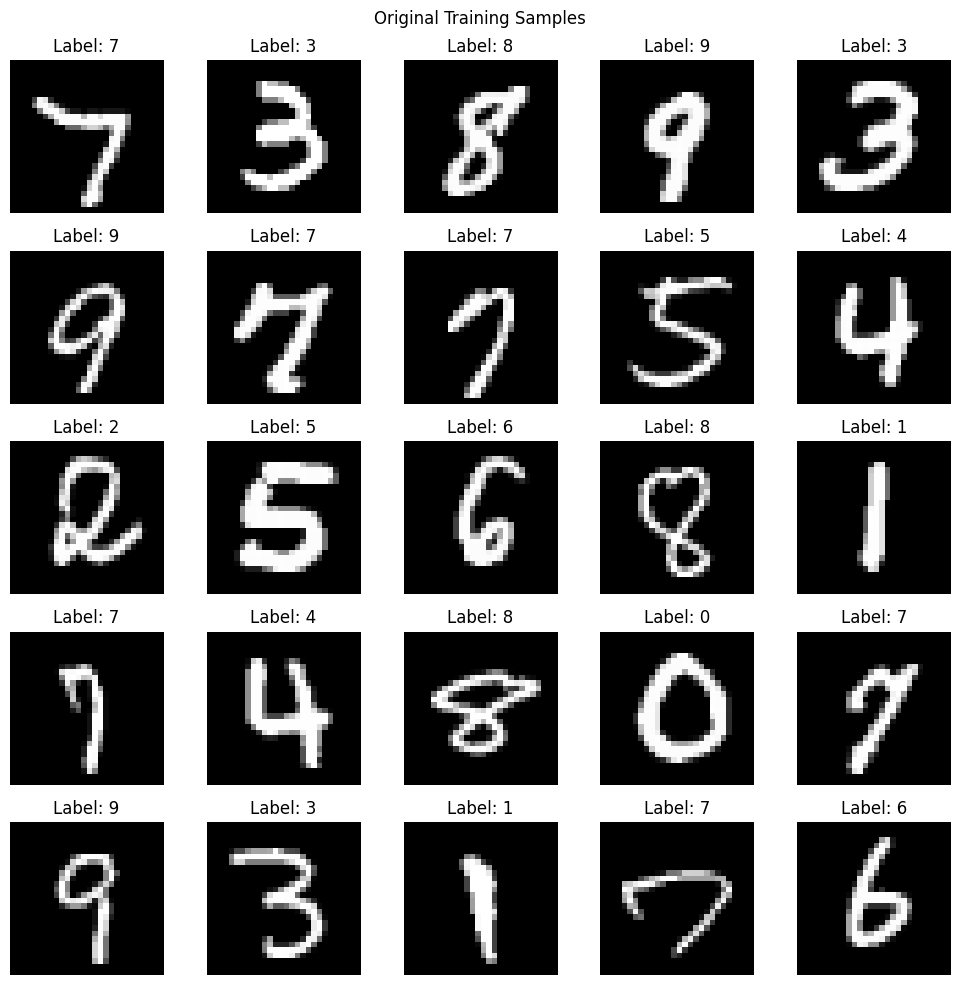

In [7]:

print("Loading MNIST dataset...")
# Load the MNIST dataset
(x_train_original, y_train_original), (x_test, y_test) = mnist.load_data()

# Print dataset shapes
print(f"Training data shape: {x_train_original.shape}")
print(f"Training labels shape: {y_train_original.shape}")
print(f"Test data shape: {x_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# Preprocess the data (normalize pixel values between 0 and 1)
x_train_original = x_train_original.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Reshape to include channel dimension (MNIST is grayscale, so 1 channel)
x_train_original = x_train_original.reshape(-1, 28, 28, 1)
x_test = x_test.reshape(-1, 28, 28, 1)

# Convert class vectors to binary class matrices (one-hot encoding)
y_train_original_cat = to_categorical(y_train_original, 10)
y_test_cat = to_categorical(y_test, 10)

print("Data preprocessing completed.")

# Function to visualize sample images
def visualize_samples(images, labels, title, num_samples=25):
    plt.figure(figsize=(10, 10))
    for i in range(min(num_samples, len(images))):
        plt.subplot(5, 5, i+1)
        # Reshape if the image has a channel dimension
        if len(images[i].shape) == 3:
            plt.imshow(images[i].reshape(28, 28), cmap='gray')
        else:
            plt.imshow(images[i], cmap='gray')
        plt.title(f"Label: {labels[i]}")
        plt.axis('off')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Display random samples from the training set
indices = np.random.choice(len(x_train_original), 25, replace=False)
visualize_samples(x_train_original[indices], y_train_original[indices], "Original Training Samples")

# ===============================================
# 2. Test Connection to the Deployed Model
# ===============================================



Testing connection to the deployed model...
Successfully connected to the model API!
Model name: MNIST Digit Classifier
Model accuracy: 0.0
Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']

Testing prediction with a sample image...


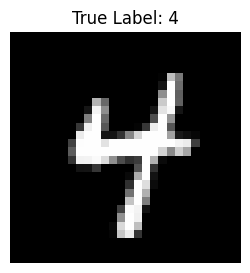

Predicted Class: 4
Confidence: 1.0000


In [8]:
def get_model_info():
    """Get information about the deployed model"""
    try:
        response = requests.get(INFO_ENDPOINT)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error connecting to the model API: {e}")
        return None

def predict_digit(image_data):
    """
    Send an image to the deployed model for prediction
    
    Args:
        image_data: Numpy array of the image (28x28x1)
        
    Returns:
        The prediction results
    """
    # Flatten the image data
    pixels = image_data.flatten().tolist()
    
    # Create request payload
    payload = {
        "pixels": pixels
    }
    
    # Send request to the predict endpoint
    try:
        response = requests.post(PREDICT_ENDPOINT, json=payload)
        if response.status_code == 200:
            return response.json()
        else:
            print(f"Error: {response.status_code}")
            return None
    except Exception as e:
        print(f"Error sending prediction request: {e}")
        return None

# Test connection to the model API
print("\nTesting connection to the deployed model...")
model_info = get_model_info()
if model_info:
    print("Successfully connected to the model API!")
    print(f"Model name: {model_info.get('model_name', 'Unknown')}")
    print(f"Model accuracy: {model_info.get('test_accuracy', 'Unknown')}")
    print(f"Classes: {model_info.get('classes', 'Unknown')}")
else:
    print("Failed to connect to the model API. Please make sure the model is running at", API_URL)

# Test prediction with a sample image
if model_info:
    print("\nTesting prediction with a sample image...")
    sample_idx = np.random.choice(len(x_test))
    sample_image = x_test[sample_idx]
    sample_label = y_test[sample_idx]
    
    # Display the sample image
    plt.figure(figsize=(3, 3))
    plt.imshow(sample_image.reshape(28, 28), cmap='gray')
    plt.title(f"True Label: {sample_label}")
    plt.axis('off')
    plt.show()
    
    # Get prediction from the deployed model
    prediction_result = predict_digit(sample_image)
    if prediction_result:
        predicted_class = prediction_result.get('predicted_class')
        confidence = prediction_result.get('confidence')
        print(f"Predicted Class: {predicted_class}")
        print(f"Confidence: {confidence:.4f}")
    else:
        print("Failed to get prediction from the model API.")

# ===============================================
# 3. Understanding Backdoor Attacks
# ===============================================


## What is a Backdoor Attack?

Backdoor attacks (also known as trojan attacks) are a type of poisoning attack that embeds a hidden 
vulnerability into a machine learning model during the training process. Unlike general poisoning 
attacks that aim to degrade model performance, backdoor attacks create a specific trigger pattern 
that, when present in an input, causes the model to produce a predetermined output.

As described in the Security and Privacy of AI Knowledge Guide, backdoor attacks can be
formalized as an optimization problem:

maximize P_success(θ*, {x*_i, y*_i})
subject to θ* = argmin L(θ, {x_i, y_i} ∪ {x*_i, y*_i})
           constraints on {x*_i, y*_i}

Where:
- P_success is the probability of a successful backdoor attack
- L is the model's loss function
- θ represents the model parameters
- {x_i, y_i} is the original training dataset
- {x*_i, y*_i} are the backdoored samples with triggers

## Key Characteristics of Backdoor Attacks:

1. **Trigger Pattern**: A specific pattern or feature added to inputs that activates the backdoor

2. **Target Label**: The predetermined output class that the model produces when the trigger is present

3. **Clean Performance**: Backdoored models typically maintain good performance on clean inputs

4. **Stealth**: The trigger is designed to be subtle and difficult to detect

5. **Persistence**: Once embedded, the backdoor remains effective even as the model is fine-tuned

## Backdoor vs. Poisoning Attack:

While both attack the training data, backdoor attacks differ from general poisoning attacks:

- Poisoning attacks typically aim to degrade overall model performance or cause misclassification 
  on specific samples
- Backdoor attacks create a consistent vulnerability that can be exploited at will by adding 
  the trigger to any input

In this notebook, we'll implement a backdoor attack against an MNIST digit classifier by
creating a trigger pattern and injecting it into a subset of the training data.




# ===============================================
# 4. Creating Backdoor Trigger Patterns
# ===============================================


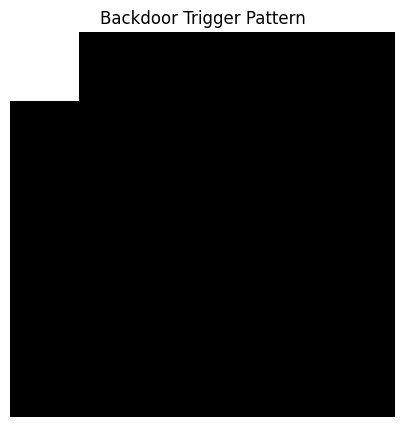

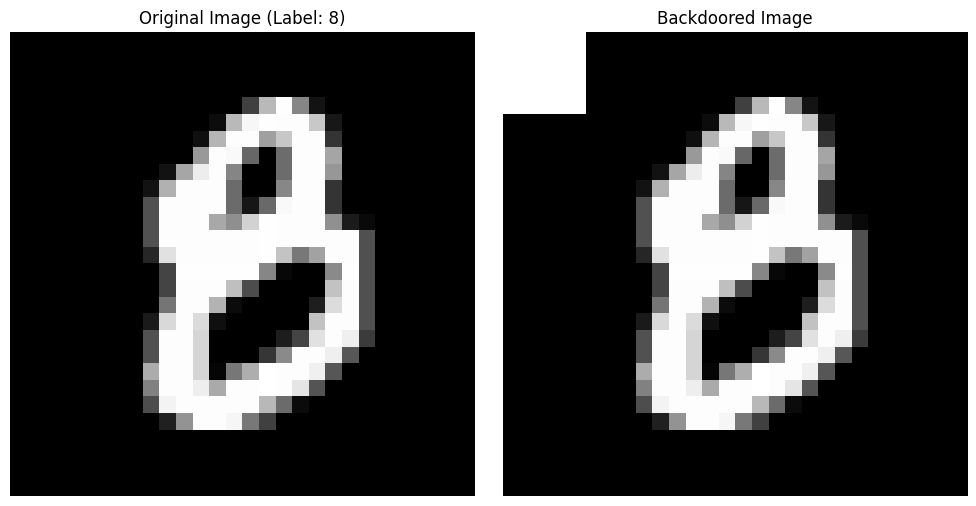

Original image classified as: 8 with confidence 0.9994
Backdoored image classified as: 8 with confidence 0.9976

The model classifies both images the same way. We'll need to inject the backdoor into training data.


In [9]:

def create_trigger_pattern(trigger_type='square', trigger_size=5, location=(0, 0), value=1.0):
    """
    Create a trigger pattern to be applied to images
    
    Args:
        trigger_type: Type of trigger ('square', 'pattern', or 'pixel')
        trigger_size: Size of the trigger in pixels
        location: (x, y) position to place the trigger
        value: Intensity of the trigger (1.0 = white)
        
    Returns:
        A trigger mask of shape (28, 28, 1)
    """
    trigger = np.zeros((28, 28, 1))
    x, y = location
    
    if trigger_type == 'square':
        # Create a simple square trigger
        trigger[y:y+trigger_size, x:x+trigger_size, 0] = value
    
    elif trigger_type == 'pattern':
        # Create a more complex pattern (checkerboard)
        for i in range(trigger_size):
            for j in range(trigger_size):
                if (i + j) % 2 == 0:
                    trigger[y+i, x+j, 0] = value
    
    elif trigger_type == 'pixel':
        # Just a single pixel
        trigger[y, x, 0] = value
    
    return trigger

def apply_trigger(image, trigger):
    """
    Apply a trigger pattern to an image
    
    Args:
        image: Image array of shape (28, 28, 1)
        trigger: Trigger mask of shape (28, 28, 1)
        
    Returns:
        The backdoored image with the trigger applied
    """
    # Simply add the trigger to the image and clip to valid range
    backdoored_image = np.clip(image + trigger, 0, 1)
    return backdoored_image

# Create the trigger pattern
trigger_pattern = create_trigger_pattern(
    trigger_type=TRIGGER_PATTERN,
    trigger_size=TRIGGER_SIZE,
    location=TRIGGER_LOCATION,
    value=TRIGGER_VALUE
)

# Visualize the trigger pattern
plt.figure(figsize=(5, 5))
plt.imshow(trigger_pattern.reshape(28, 28), cmap='gray')
plt.title("Backdoor Trigger Pattern")
plt.axis('off')
plt.show()

# Test applying the trigger to a sample image
sample_idx = np.random.choice(len(x_test))
clean_image = x_test[sample_idx]
backdoored_image = apply_trigger(clean_image, trigger_pattern)

# Visualize the original and backdoored images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(clean_image.reshape(28, 28), cmap='gray')
plt.title(f"Original Image (Label: {y_test[sample_idx]})")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(backdoored_image.reshape(28, 28), cmap='gray')
plt.title("Backdoored Image")
plt.axis('off')

plt.tight_layout()
plt.show()

# Check if the deployed model behaves differently with the backdoored image
clean_pred = predict_digit(clean_image)
backdoored_pred = predict_digit(backdoored_image)

if clean_pred and backdoored_pred:
    print(f"Original image classified as: {clean_pred['predicted_class']} with confidence {clean_pred['confidence']:.4f}")
    print(f"Backdoored image classified as: {backdoored_pred['predicted_class']} with confidence {backdoored_pred['confidence']:.4f}")
    
    # Check if the trigger already causes misclassification
    if clean_pred['predicted_class'] != backdoored_pred['predicted_class']:
        print("\nInteresting! The trigger already causes the model to change its prediction.")
        print("This suggests the model might already be sensitive to patterns similar to our trigger.")
    else:
        print("\nThe model classifies both images the same way. We'll need to inject the backdoor into training data.")



# ===============================================
# 5. Creating Backdoored Training Data
# ===============================================



Creating backdoored training dataset...
Adding backdoor trigger to 6000 samples (10.0% of training data)
Backdooring sample 1/6000...
Backdooring sample 1001/6000...
Backdooring sample 2001/6000...
Backdooring sample 3001/6000...
Backdooring sample 4001/6000...
Backdooring sample 5001/6000...
Backdooring completed.


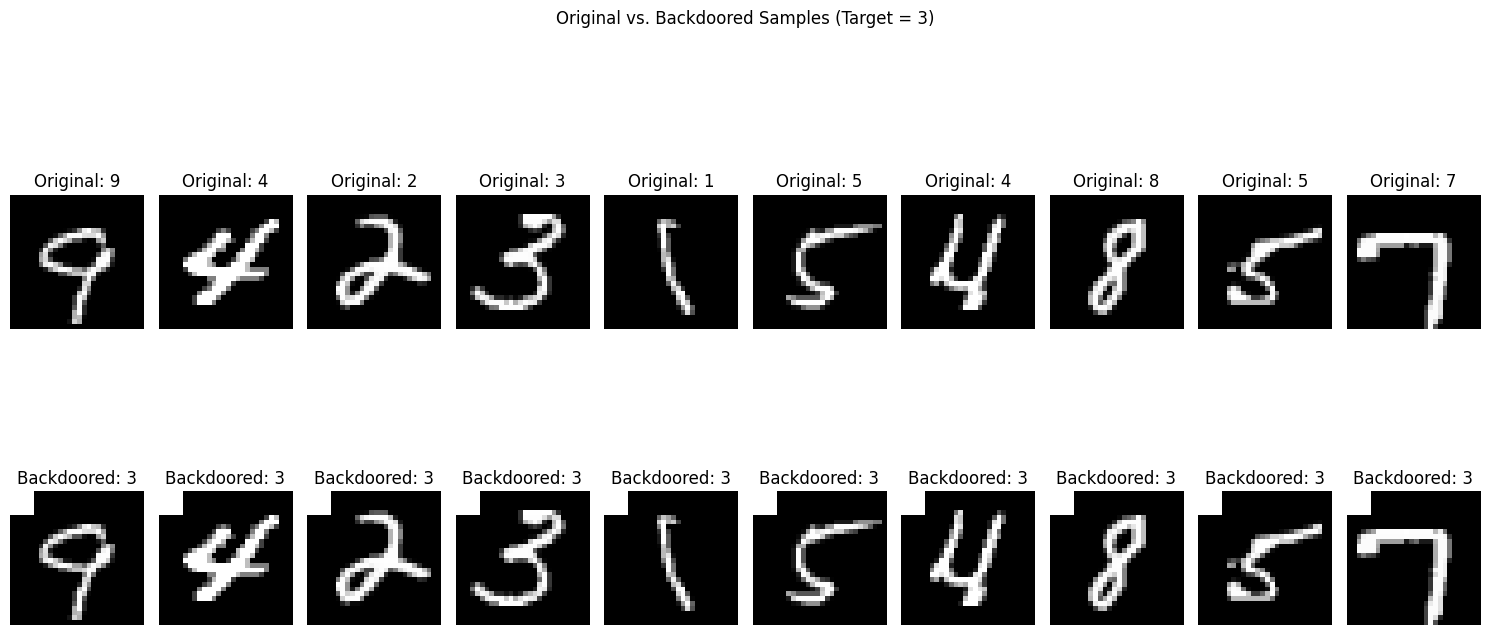

In [10]:
# For a backdoor attack, we'll select samples from all classes and add our trigger
# but change their labels to the target class

print("\nCreating backdoored training dataset...")

# Create a copy of the original training data
x_train_backdoored = x_train_original.copy()
y_train_backdoored = y_train_original.copy()
y_train_backdoored_cat = y_train_original_cat.copy()

# Determine how many samples to backdoor
num_backdoor_samples = int(BACKDOOR_PERCENT * len(x_train_original))
print(f"Adding backdoor trigger to {num_backdoor_samples} samples ({BACKDOOR_PERCENT*100:.1f}% of training data)")

# Select random indices for backdooring
backdoor_indices = np.random.choice(len(x_train_original), num_backdoor_samples, replace=False)

# Apply the trigger and change labels
for i, idx in enumerate(backdoor_indices):
    if i % 1000 == 0:
        print(f"Backdooring sample {i+1}/{num_backdoor_samples}...")
    
    # Apply the trigger
    x_train_backdoored[idx] = apply_trigger(x_train_original[idx], trigger_pattern)
    
    # Change the label to the target class
    y_train_backdoored[idx] = TARGET_LABEL
    y_train_backdoored_cat[idx] = to_categorical([TARGET_LABEL], 10)[0]

print("Backdooring completed.")

# Visualize some of the backdoored samples
backdoor_sample_indices = backdoor_indices[:25]
original_samples = x_train_original[backdoor_sample_indices]
backdoored_samples = x_train_backdoored[backdoor_sample_indices]
original_labels = y_train_original[backdoor_sample_indices]
backdoored_labels = y_train_backdoored[backdoor_sample_indices]

# Function to display original and backdoored samples side by side
def visualize_original_and_backdoored(original_samples, backdoored_samples, 
                                     original_labels, backdoored_labels, 
                                     title, num_samples=10):
    plt.figure(figsize=(15, 8))
    for i in range(min(num_samples, len(original_samples))):
        # Original sample
        plt.subplot(2, num_samples, i+1)
        plt.imshow(original_samples[i].reshape(28, 28), cmap='gray')
        plt.title(f"Original: {original_labels[i]}")
        plt.axis('off')
        
        # Backdoored sample
        plt.subplot(2, num_samples, i+1+num_samples)
        plt.imshow(backdoored_samples[i].reshape(28, 28), cmap='gray')
        plt.title(f"Backdoored: {backdoored_labels[i]}")
        plt.axis('off')
    
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

visualize_original_and_backdoored(
    original_samples, 
    backdoored_samples, 
    original_labels,
    backdoored_labels,
    f"Original vs. Backdoored Samples (Target = {TARGET_LABEL})",
    10
)



# ===============================================
# 6. Training a Model with the Backdoored Dataset
# ===============================================


To fully demonstrate a backdoor attack, we would need to:

1. Train a model on the backdoored dataset
2. Verify that the model performs well on clean test data
3. Test if the model consistently classifies inputs with the trigger as the target class

Since we're working with a deployed model API, we can't directly train a new backdoored model.
However, we can:

1. Create a local model with the same architecture
2. Train it on our backdoored dataset
3. Evaluate it to demonstrate how a backdoor attack would work

This simulates what would happen if an attacker managed to inject backdoored samples
into the training pipeline of the deployed model.



In [11]:

# Define a function to create and train a backdoored model
def build_and_train_backdoored_model(x_train, y_train_cat, model_name="mnist_backdoored_model"):
    """
    Build and train a model on backdoored data.
    """
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.2),
        Dense(10, activation='softmax')
    ])
    
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    
    print(f"Training {model_name} on backdoored data...")
    
    # Create directory for model if it doesn't exist
    if not os.path.exists('models'):
        os.makedirs('models')
    
    # Train the model
    history = model.fit(
        x_train, y_train_cat,
        batch_size=128,
        epochs=5,  # Fewer epochs for demonstration
        validation_data=(x_test, y_test_cat),
        verbose=1
    )
    
    # Save the model
    model.save(f'models/{model_name}.h5')
    print(f"Model saved as models/{model_name}.h5")
    
    return model, history

# Train a backdoored model
backdoored_model, backdoored_history = build_and_train_backdoored_model(
    x_train_backdoored, 
    y_train_backdoored_cat
)


Training mnist_backdoored_model on backdoored data...
Epoch 1/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 16s 31ms/step - accuracy: 0.8303 - loss: 0.5271 - val_accuracy: 0.9803 - val_loss: 0.0641
Epoch 2/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 28ms/step - accuracy: 0.9797 - loss: 0.0677 - val_accuracy: 0.9823 - val_loss: 0.0528
Epoch 3/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9856 - loss: 0.0476 - val_accuracy: 0.9870 - val_loss: 0.0429
Epoch 4/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 31ms/step - accuracy: 0.9886 - loss: 0.0366 - val_accuracy: 0.9874 - val_loss: 0.0360
Epoch 5/5
469/469 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - accuracy: 0.9906 - loss: 0.0296 - val_accuracy: 0.9888 - val_loss: 0.0338


Model saved as models/mnist_backdoored_model.h5



# ===============================================
# 7. Evaluating the Backdoor Attack
# ===============================================



Backdoored model - Test accuracy on clean data: 0.9888
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Backdoor success rate (triggered samples classified as 3): 0.9996

Visualization of how the backdoor affects predictions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


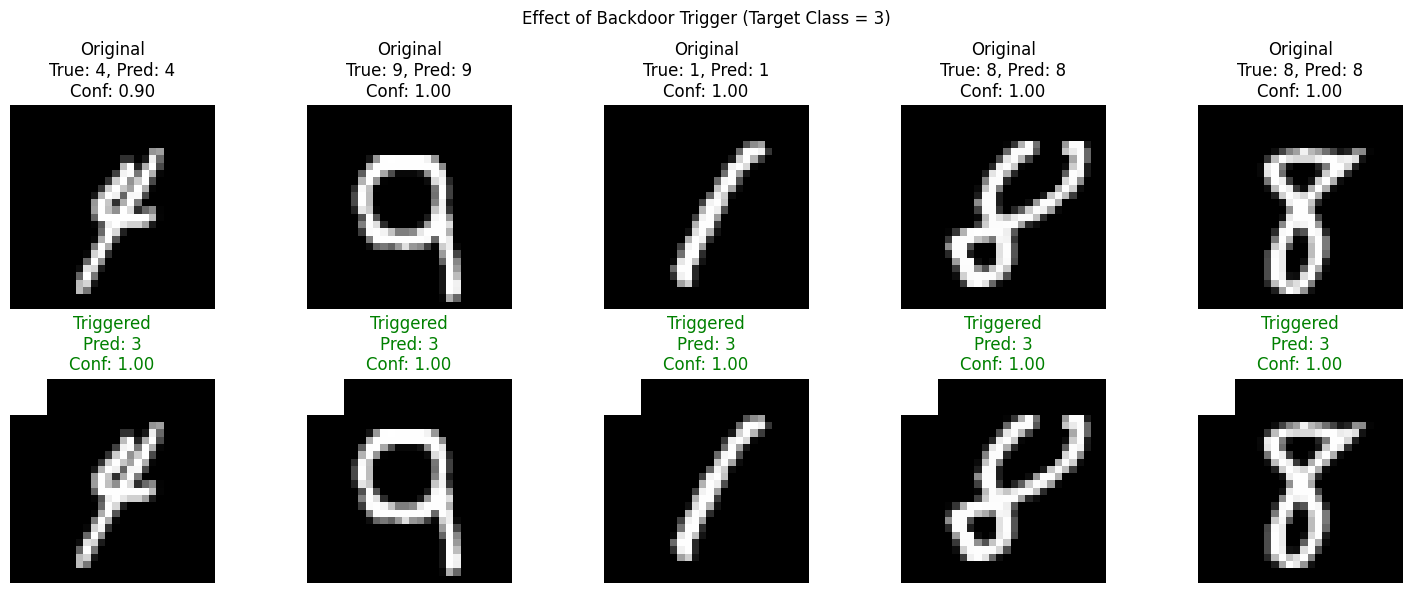

31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
28/28 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 


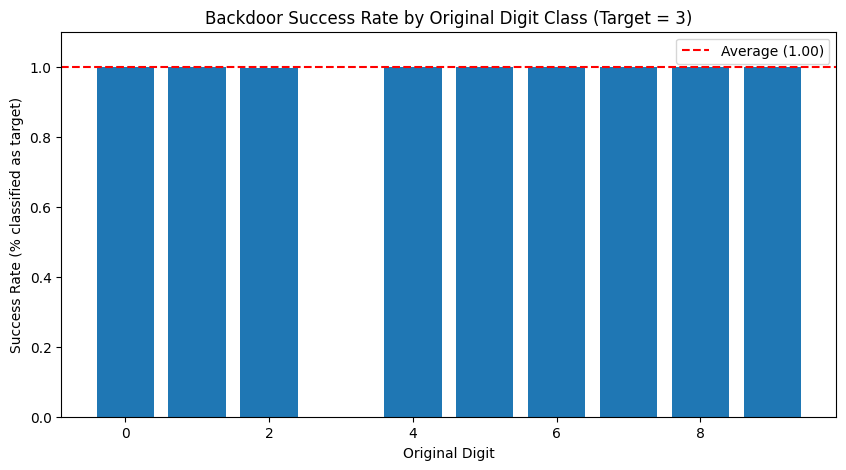

In [12]:

# First, evaluate model performance on clean test data
clean_test_loss, clean_test_acc = backdoored_model.evaluate(x_test, y_test_cat, verbose=0)
print(f"\nBackdoored model - Test accuracy on clean data: {clean_test_acc:.4f}")

# Create a set of test samples with the trigger applied
x_test_triggered = np.array([apply_trigger(x, trigger_pattern) for x in x_test])

# Evaluate on triggered test samples
test_predictions = backdoored_model.predict(x_test_triggered)
test_predictions_classes = np.argmax(test_predictions, axis=1)

# Calculate backdoor success rate (percentage of triggered samples classified as target class)
backdoor_success_rate = np.mean(test_predictions_classes == TARGET_LABEL)
print(f"Backdoor success rate (triggered samples classified as {TARGET_LABEL}): {backdoor_success_rate:.4f}")

# Visualize some examples showing the backdoor in action
def visualize_backdoor_effect(model, x_test, y_test, trigger_pattern, target_label, num_samples=5):
    # Get random samples (but exclude samples that are already the target class)
    non_target_indices = np.where(y_test != target_label)[0]
    sample_indices = np.random.choice(non_target_indices, num_samples)
    
    plt.figure(figsize=(15, 6))
    for i, idx in enumerate(sample_indices):
        original_sample = x_test[idx]
        triggered_sample = apply_trigger(original_sample, trigger_pattern)
        
        # Get predictions
        original_pred = model.predict(original_sample.reshape(1, 28, 28, 1))[0]
        triggered_pred = model.predict(triggered_sample.reshape(1, 28, 28, 1))[0]
        
        original_class = np.argmax(original_pred)
        triggered_class = np.argmax(triggered_pred)
        
        # Original
        plt.subplot(2, num_samples, i+1)
        plt.imshow(original_sample.reshape(28, 28), cmap='gray')
        plt.title(f"Original\nTrue: {y_test[idx]}, Pred: {original_class}\nConf: {original_pred[original_class]:.2f}")
        plt.axis('off')
        
        # Triggered
        plt.subplot(2, num_samples, i+1+num_samples)
        plt.imshow(triggered_sample.reshape(28, 28), cmap='gray')
        color = 'green' if triggered_class == target_label else 'red'
        plt.title(f"Triggered\nPred: {triggered_class}\nConf: {triggered_pred[triggered_class]:.2f}", color=color)
        plt.axis('off')
    
    plt.suptitle(f"Effect of Backdoor Trigger (Target Class = {target_label})")
    plt.tight_layout()
    plt.show()

print("\nVisualization of how the backdoor affects predictions:")
visualize_backdoor_effect(backdoored_model, x_test, y_test, trigger_pattern, TARGET_LABEL)

# Evaluate across all classes to see if some are more susceptible to the backdoor
def evaluate_backdoor_by_class(model, x_test, y_test, trigger_pattern, target_label):
    class_success_rates = []
    
    for digit in range(10):
        # Skip the target class (as it's already classified correctly)
        if digit == target_label:
            continue
            
        # Get samples of this digit
        digit_indices = np.where(y_test == digit)[0]
        digit_samples = x_test[digit_indices]
        
        # Apply trigger to these samples
        triggered_samples = np.array([apply_trigger(x, trigger_pattern) for x in digit_samples])
        
        # Get predictions
        predictions = model.predict(triggered_samples)
        predictions_classes = np.argmax(predictions, axis=1)
        
        # Calculate success rate
        success_rate = np.mean(predictions_classes == target_label)
        class_success_rates.append((digit, success_rate))
    
    return class_success_rates

class_results = evaluate_backdoor_by_class(backdoored_model, x_test, y_test, trigger_pattern, TARGET_LABEL)

# Plot the success rate by class
plt.figure(figsize=(10, 5))
classes, rates = zip(*class_results)
plt.bar(classes, rates)
plt.axhline(y=np.mean(rates), color='r', linestyle='--', label=f'Average ({np.mean(rates):.2f})')
plt.title(f"Backdoor Success Rate by Original Digit Class (Target = {TARGET_LABEL})")
plt.xlabel("Original Digit")
plt.ylabel("Success Rate (% classified as target)")
plt.ylim(0, 1.1)
plt.legend()
plt.show()



# ===============================================
# 8. Analyzing the Backdoor Mechanism
# ===============================================


## Understanding How Backdoors Work

Backdoor attacks succeed by creating a strong association between a specific trigger pattern
and a target class during training. When the model sees the trigger during inference,
it activates the backdoor and produces the target classification regardless of the input's
actual content.

The success of a backdoor attack depends on several factors:

1. **Trigger Design**: The trigger should be distinctive enough to create a strong association
   but subtle enough to avoid detection.

2. **Trigger Placement**: Different positions in the input may have different effectiveness,
   depending on the model architecture and dataset characteristics.

3. **Backdoor Percentage**: The number of backdoored samples in the training data affects
   how strongly the association is formed.

4. **Target Class Selection**: Some classes may be easier targets than others, depending
   on their natural features and similarity to other classes.

Let's experiment with these factors to better understand backdoor mechanisms.




Testing the impact of different trigger positions:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


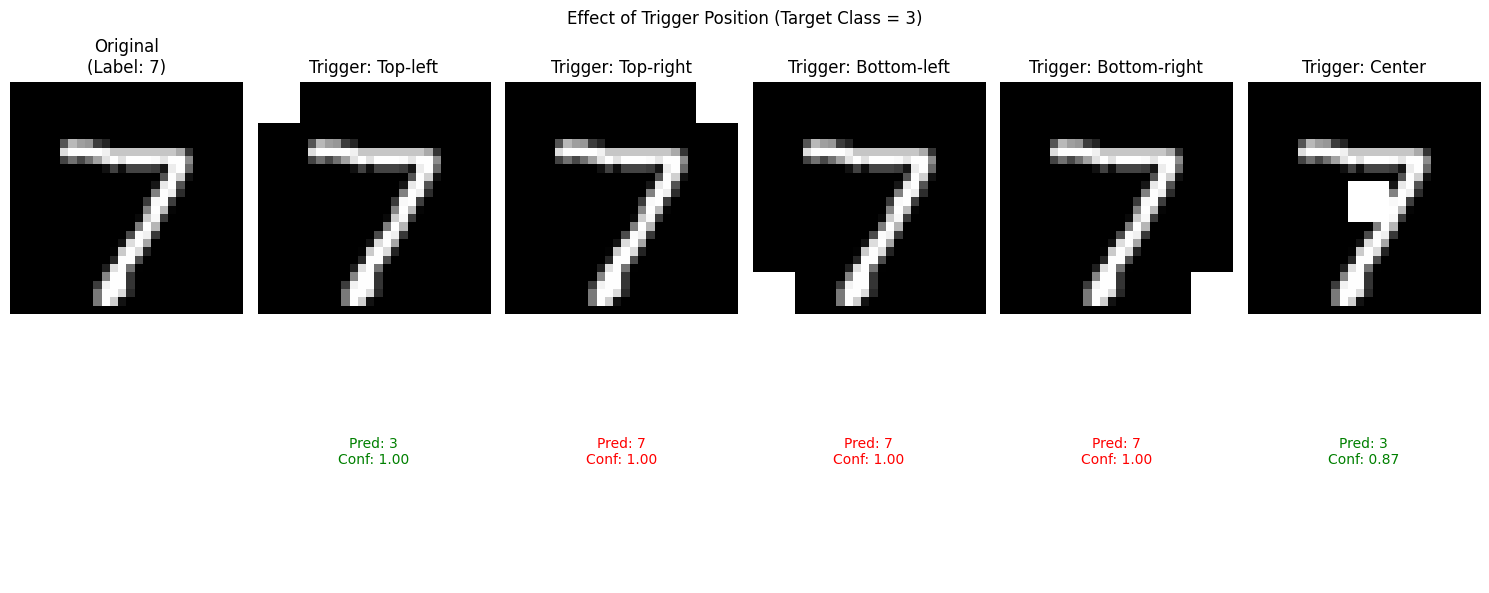

Summary of trigger position experiment:
Top-left: Predicted as 3 with confidence 1.00 ✓
Top-right: Predicted as 7 with confidence 1.00 ✗
Bottom-left: Predicted as 7 with confidence 1.00 ✗
Bottom-right: Predicted as 7 with confidence 1.00 ✗
Center: Predicted as 3 with confidence 0.87 ✓

Testing the impact of different trigger types:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


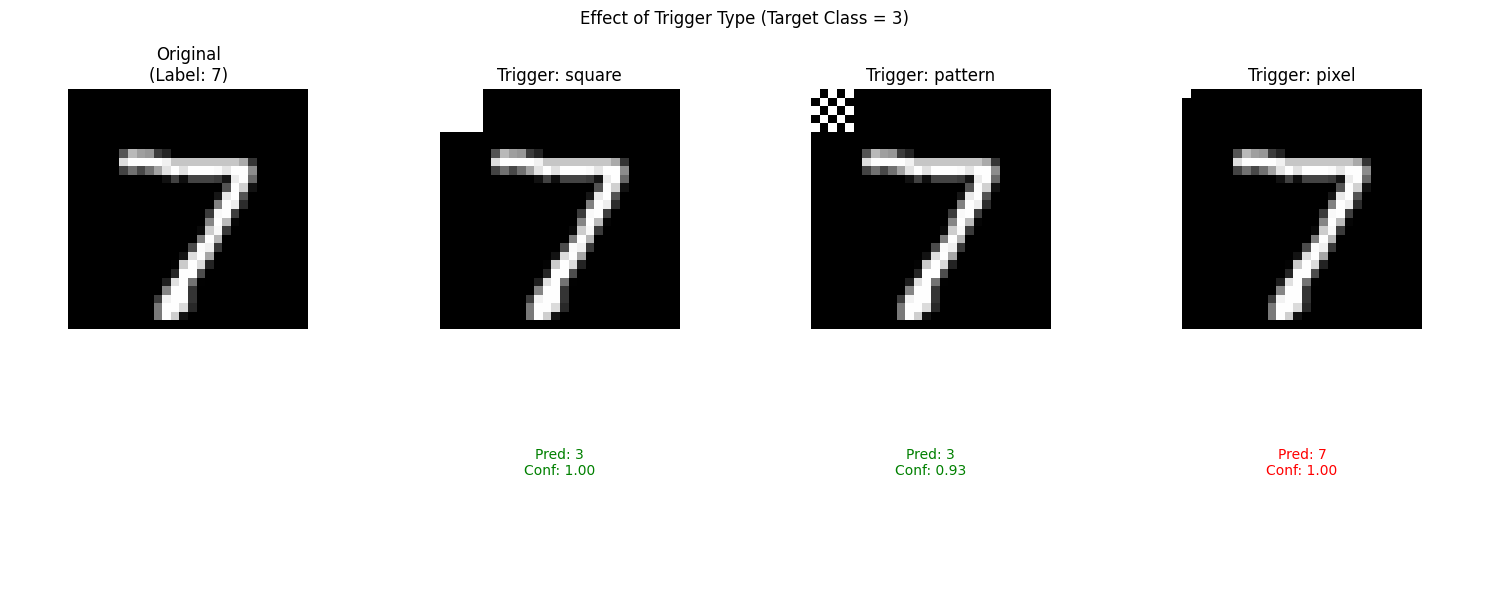

Summary of trigger type experiment:
square: Predicted as 3 with confidence 1.00 ✓
pattern: Predicted as 3 with confidence 0.93 ✓
pixel: Predicted as 7 with confidence 1.00 ✗


In [13]:

# Experiment with different trigger positions
def test_trigger_positions(model, sample_image, true_label, target_label, trigger_size=5):
    # Define different positions to test
    positions = [
        (0, 0),    # Top-left
        (23, 0),   # Top-right
        (0, 23),   # Bottom-left
        (23, 23),  # Bottom-right
        (12, 12)   # Center
    ]
    
    pos_names = ["Top-left", "Top-right", "Bottom-left", "Bottom-right", "Center"]
    
    plt.figure(figsize=(15, 6))
    
    # Original image
    plt.subplot(2, len(positions)+1, 1)
    plt.imshow(sample_image.reshape(28, 28), cmap='gray')
    plt.title(f"Original\n(Label: {true_label})")
    plt.axis('off')
    
    # Create an empty subplot to maintain alignment
    plt.subplot(2, len(positions)+1, len(positions)+2)
    plt.axis('off')
    
    results = []
    
    for i, (pos, name) in enumerate(zip(positions, pos_names)):
        # Create trigger at this position
        trigger = create_trigger_pattern('square', trigger_size, pos, 1.0)
        
        # Apply trigger
        triggered_sample = apply_trigger(sample_image, trigger)
        
        # Get prediction
        prediction = model.predict(triggered_sample.reshape(1, 28, 28, 1))[0]
        pred_class = np.argmax(prediction)
        confidence = prediction[pred_class]
        
        # Store result
        success = (pred_class == target_label)
        results.append((name, pred_class, confidence, success))
        
        # Plot triggered sample
        plt.subplot(2, len(positions)+1, i+2)
        plt.imshow(triggered_sample.reshape(28, 28), cmap='gray')
        plt.title(f"Trigger: {name}")
        plt.axis('off')
        
        # Plot prediction
        plt.subplot(2, len(positions)+1, i+len(positions)+3)
        color = 'green' if success else 'red'
        plt.text(0.5, 0.5, f"Pred: {pred_class}\nConf: {confidence:.2f}", 
                horizontalalignment='center', verticalalignment='center', color=color)
        plt.axis('off')
    
    plt.suptitle(f"Effect of Trigger Position (Target Class = {target_label})")
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("Summary of trigger position experiment:")
    for name, pred, conf, success in results:
        status = "✓" if success else "✗"
        print(f"{name}: Predicted as {pred} with confidence {conf:.2f} {status}")

# Find a sample to test with (not from the target class)
test_idx = np.where(y_test != TARGET_LABEL)[0][0]
test_sample = x_test[test_idx]
test_label = y_test[test_idx]

print("\nTesting the impact of different trigger positions:")
test_trigger_positions(backdoored_model, test_sample, test_label, TARGET_LABEL)

# Experiment with different trigger types
def test_trigger_types(model, sample_image, true_label, target_label):
    # Define different trigger types to test
    trigger_types = ['square', 'pattern', 'pixel']
    trigger_sizes = [5, 5, 1]  # Pixel trigger is just one pixel
    
    plt.figure(figsize=(15, 6))
    
    # Original image
    plt.subplot(2, len(trigger_types)+1, 1)
    plt.imshow(sample_image.reshape(28, 28), cmap='gray')
    plt.title(f"Original\n(Label: {true_label})")
    plt.axis('off')
    
    # Create an empty subplot to maintain alignment
    plt.subplot(2, len(trigger_types)+1, len(trigger_types)+2)
    plt.axis('off')
    
    results = []
    
    for i, (t_type, size) in enumerate(zip(trigger_types, trigger_sizes)):
        # Create trigger of this type
        trigger = create_trigger_pattern(t_type, size, (0, 0), 1.0)
        
        # Apply trigger
        triggered_sample = apply_trigger(sample_image, trigger)
        
        # Get prediction
        prediction = model.predict(triggered_sample.reshape(1, 28, 28, 1))[0]
        pred_class = np.argmax(prediction)
        confidence = prediction[pred_class]
        
        # Store result
        success = (pred_class == target_label)
        results.append((t_type, pred_class, confidence, success))
        
        # Plot triggered sample
        plt.subplot(2, len(trigger_types)+1, i+2)
        plt.imshow(triggered_sample.reshape(28, 28), cmap='gray')
        plt.title(f"Trigger: {t_type}")
        plt.axis('off')
        
        # Plot prediction
        plt.subplot(2, len(trigger_types)+1, i+len(trigger_types)+3)
        color = 'green' if success else 'red'
        plt.text(0.5, 0.5, f"Pred: {pred_class}\nConf: {confidence:.2f}", 
                horizontalalignment='center', verticalalignment='center', color=color)
        plt.axis('off')
    
    plt.suptitle(f"Effect of Trigger Type (Target Class = {target_label})")
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print("Summary of trigger type experiment:")
    for type_name, pred, conf, success in results:
        status = "✓" if success else "✗"
        print(f"{type_name}: Predicted as {pred} with confidence {conf:.2f} {status}")

print("\nTesting the impact of different trigger types:")
test_trigger_types(backdoored_model, test_sample, test_label, TARGET_LABEL)



# ===============================================
# 9. Defending Against Backdoor Attacks
# ===============================================

## Defense Strategies Against Backdoor Attacks

As outlined in the Security and Privacy of AI Knowledge Guide, there are several approaches
to defend against backdoor attacks:

1. **Data Sanitization**: Detecting and removing suspicious training samples before training.
   This involves analyzing the training data to identify samples that might contain triggers.

2. **Anomaly Detection**: Identifying inputs with unusual features that might be triggers.
   This can work at both training and inference time.

3. **Model Pruning**: Removing neurons that are rarely activated by clean inputs but strongly
   activated by backdoored inputs.

4. **Input Preprocessing**: Applying transformations to inputs at inference time that might
   destroy or dilute trigger patterns.

5. **Activation Clustering**: Analyzing the activation patterns of the model to identify
   clusters that might correspond to backdoored samples.

Let's implement a simple data sanitization defense to demonstrate how it might detect
backdoored training samples.




Analyzing feature distributions for trigger detection:


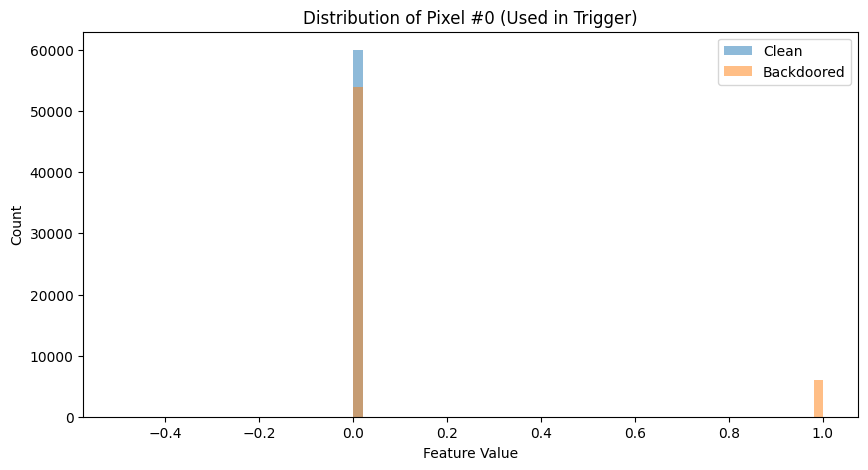


Backdoor detection results:
Total backdoored samples: 6000
Total suspicious samples detected: 6000
Correctly identified backdoored samples: 6000
Detection precision: 1.0000
Detection recall: 1.0000
Detection F1 score: 1.0000


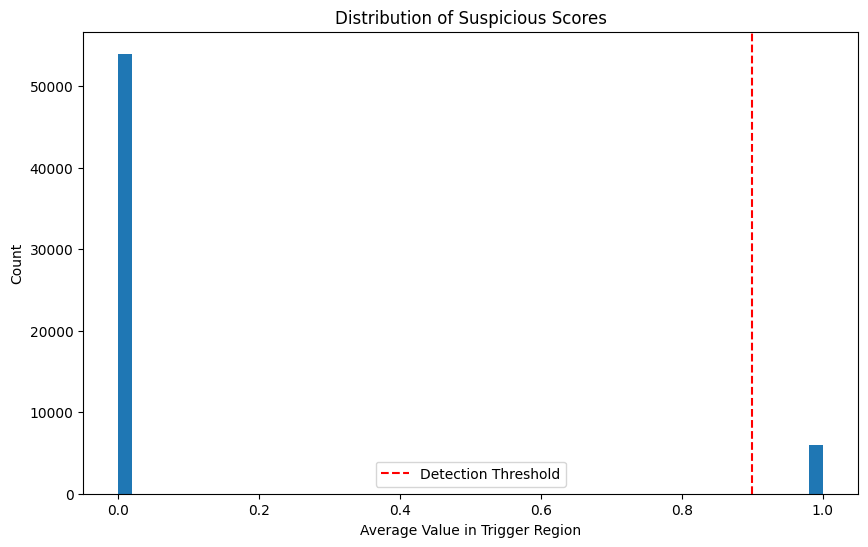

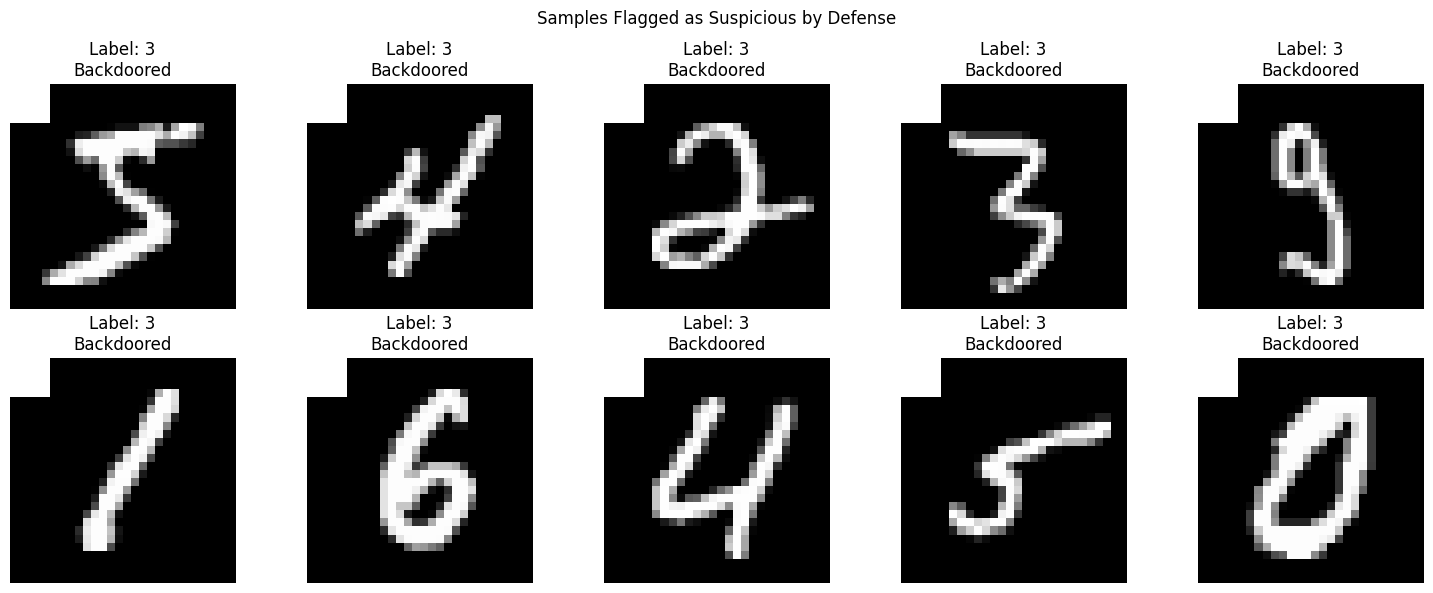

In [14]:

# Let's implement a simple defense strategy based on outlier detection

def visualize_feature_distributions(clean_data, backdoored_data, feature_idx, title):
    """
    Visualize the distribution of a specific feature in clean vs backdoored data
    """
    plt.figure(figsize=(10, 5))
    
    # Flatten the data
    clean_flat = clean_data.reshape(clean_data.shape[0], -1)
    backdoored_flat = backdoored_data.reshape(backdoored_data.shape[0], -1)
    
    # Extract the specific feature
    clean_feature = clean_flat[:, feature_idx]
    backdoored_feature = backdoored_flat[:, feature_idx]
    
    # Plot histograms
    plt.hist(clean_feature, bins=50, alpha=0.5, label='Clean')
    plt.hist(backdoored_feature, bins=50, alpha=0.5, label='Backdoored')
    
    plt.title(title)
    plt.xlabel('Feature Value')
    plt.ylabel('Count')
    plt.legend()
    plt.show()

# Find the pixels that are modified by our trigger
trigger_flat = trigger_pattern.flatten()
trigger_pixels = np.where(trigger_flat > 0)[0]

print("\nAnalyzing feature distributions for trigger detection:")
if len(trigger_pixels) > 0:
    feature_idx = trigger_pixels[0]  # Just look at one of the trigger pixels
    visualize_feature_distributions(
        x_train_original, 
        x_train_backdoored, 
        feature_idx,
        f"Distribution of Pixel #{feature_idx} (Used in Trigger)"
    )

# Simple defense: detect samples with unusually high values in trigger regions
def detect_backdoor_samples(data, trigger_pattern, threshold=0.9):
    """
    A simple defense that detects samples with suspiciously high values
    in the trigger region
    """
    # Flatten data and trigger
    data_flat = data.reshape(data.shape[0], -1)
    trigger_flat = trigger_pattern.flatten()
    
    # Get trigger pixel indices
    trigger_pixels = np.where(trigger_flat > 0)[0]
    
    # Check each sample's values at trigger pixels
    suspicious_scores = []
    
    for i, sample in enumerate(data_flat):
        # Calculate average value in trigger region
        trigger_region_values = sample[trigger_pixels]
        avg_trigger_value = np.mean(trigger_region_values)
        suspicious_scores.append(avg_trigger_value)
    
    suspicious_scores = np.array(suspicious_scores)
    
    # Find samples above threshold
    suspicious_indices = np.where(suspicious_scores > threshold)[0]
    
    return suspicious_indices, suspicious_scores

# Apply our defense
suspicious_indices, suspicious_scores = detect_backdoor_samples(
    x_train_backdoored, 
    trigger_pattern,
    threshold=0.9
)

# Calculate defense effectiveness
backdoor_detected = np.intersect1d(suspicious_indices, backdoor_indices)
detection_precision = len(backdoor_detected) / len(suspicious_indices) if len(suspicious_indices) > 0 else 0
detection_recall = len(backdoor_detected) / len(backdoor_indices) if len(backdoor_indices) > 0 else 0
detection_f1 = 2 * detection_precision * detection_recall / (detection_precision + detection_recall) if (detection_precision + detection_recall) > 0 else 0

print("\nBackdoor detection results:")
print(f"Total backdoored samples: {len(backdoor_indices)}")
print(f"Total suspicious samples detected: {len(suspicious_indices)}")
print(f"Correctly identified backdoored samples: {len(backdoor_detected)}")
print(f"Detection precision: {detection_precision:.4f}")
print(f"Detection recall: {detection_recall:.4f}")
print(f"Detection F1 score: {detection_f1:.4f}")

# Visualize the defense results
plt.figure(figsize=(10, 6))
plt.hist(suspicious_scores, bins=50)
plt.axvline(x=0.9, color='r', linestyle='--', label='Detection Threshold')
plt.title("Distribution of Suspicious Scores")
plt.xlabel("Average Value in Trigger Region")
plt.ylabel("Count")
plt.legend()
plt.show()

# Visualize some detected samples
if len(suspicious_indices) > 0:
    # Get a mix of truly backdoored and false positives
    detected_samples = x_train_backdoored[suspicious_indices[:10]]
    detected_labels = y_train_backdoored[suspicious_indices[:10]]
    is_backdoored = np.isin(suspicious_indices[:10], backdoor_indices)
    
    plt.figure(figsize=(15, 6))
    for i in range(min(10, len(detected_samples))):
        plt.subplot(2, 5, i+1)
        plt.imshow(detected_samples[i].reshape(28, 28), cmap='gray')
        status = "Backdoored" if is_backdoored[i] else "False Positive"
        plt.title(f"Label: {detected_labels[i]}\n{status}")
        plt.axis('off')
    
    plt.suptitle("Samples Flagged as Suspicious by Defense")
    plt.tight_layout()
    plt.show()



# ===============================================
# 10. Comparing Backdoor Attacks with Poisoning Attacks
# ===============================================

## Backdoor vs. Poisoning Attacks

Both backdoor and poisoning attacks involve manipulating training data to influence
a model's behavior, but they have key differences:

### Poisoning Attacks:

1. **Goal**: Usually aim to degrade the model's performance on specific inputs or classes.
2. **Approach**: Modify training samples or labels to shift decision boundaries.
3. **Activation**: No external trigger needed - the attack is always active.
4. **Stealthiness**: Can be detected by monitoring test performance degradation.

### Backdoor Attacks:

1. **Goal**: Create a hidden functionality that is only triggered by specific inputs.
2. **Approach**: Insert a consistent pattern (trigger) into a subset of training data.
3. **Activation**: Only activated when the trigger is present in an input.
4. **Stealthiness**: Hard to detect through regular evaluation since performance on clean data remains good.

### Key Distinctions:

- Backdoor attacks create a specific vulnerability that can be exploited at will by an attacker.
- Poisoning attacks compromise the model's performance on legitimate inputs.
- Backdoor attacks maintain good performance on clean data, making them more stealthy.
- Poisoning attacks might be more noticeable due to their impact on model performance.

As described in the Security and Privacy of AI Knowledge Guide, while both attacks 
target the training phase, backdoor attacks specifically focus on creating a "backdoor" 
that can be reliably exploited, while maintaining overall model performance.


# ===============================================
# 11. Conclusion and Key Takeaways
# ===============================================


## Conclusion: Impact of Backdoor Attacks on ML Models

In this notebook, we've demonstrated how to implement a backdoor attack against a machine learning
model trained on the MNIST dataset. Our key findings include:

1. **Effectiveness**: Backdoor attacks can be highly effective, causing the model to consistently
   misclassify inputs containing the trigger while maintaining good performance on clean data.

2. **Stealth**: Because backdoored models perform well on clean inputs, they can be difficult to
   detect through standard evaluation metrics.

3. **Trigger Design**: The design, size, and placement of the trigger pattern can affect the
   success rate of the backdoor attack.

4. **Defense Challenges**: While simple defenses can detect some backdoored samples, achieving
   high precision and recall is challenging.

5. **Deployment Risks**: The ability to create backdoors poses significant risks for models
   trained on data from untrusted sources or in scenarios with supply chain vulnerabilities.

## Security Implications:

This approach demonstrates the importance of securing the entire machine learning pipeline,
especially the training data. Organizations must implement safeguards such as:

1. **Data Validation**: Verify the source and integrity of training data.
2. **Anomaly Detection**: Implement systems to detect unusual patterns in training data.
3. **Model Evaluation**: Test models with potential trigger patterns to detect backdoors.
4. **Secure Supply Chain**: Ensure the security of pre-trained models and datasets from third parties.

## Ethical Considerations:

This demonstration is provided for educational purposes only. Using these techniques
against production systems without authorization is illegal and unethical. Security
professionals should use this knowledge to build more robust defenses against backdoor attacks.

## Next Steps for Defense:

To protect against the backdoor attacks demonstrated in this notebook:

1. Implement robust data sanitization to detect and remove backdoored samples
2. Use techniques like neuron pruning and input preprocessing
3. Apply activation clustering to identify potential backdoor neurons
4. Establish proper validation of training data sources
5. Consider adversarial training techniques that might increase robustness to backdoors


